Nome: Felipe Faustino Brito

Matrícula: 2021007366

In [5]:
from scipy import signal
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from pyedflib import highlevel
import pyedflib as plib


### Gerar um sinal amostrado com 10kHz com os seguintes comandos no Python:

In [6]:
import numpy as np
Ts = 1 / 10000
t = np.arange(0,0.2,Ts)
s = 2*np.cos(2*np.pi*400*t) + 0.5*np.cos(2*np.pi*1000*t) + 1.5*np.cos(2*np.pi*1500*t) + np.cos(2*np.pi*1800*t)

In [7]:
def plot_signal(signal: np.ndarray, time: np.ndarray, frequency: float, limite=800):
    """
        Plota um sinal no domínio do tempo e sua resposta em frequência.
        
        Params:
            signal (np.ndarray): O sinal a ser plotado.
            time (np.ndarray): O array de tempos correspondente ao sinal.
            frequency (float): A frequência de amostragem do sinal (em Hz).
            limite (float, opcional): O limite superior do eixo x da resposta em frequência.
    """
    # Plotar o sinal no domínio do tempo
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title('Sinal')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Resposta em frequência (FFT)
    frequencia_fft = np.fft.fftfreq(len(signal), 1/frequency)
    espectro_fft = np.fft.fft(signal)

    # Plotar a magnitude da resposta em frequência
    plt.figure(figsize=(10, 4))
    plt.plot(frequencia_fft[:len(frequencia_fft)//2], np.abs(espectro_fft)[:len(espectro_fft)//2])
    plt.title('Resposta em frequência do sinal')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.xlim(0, limite)
    plt.show()

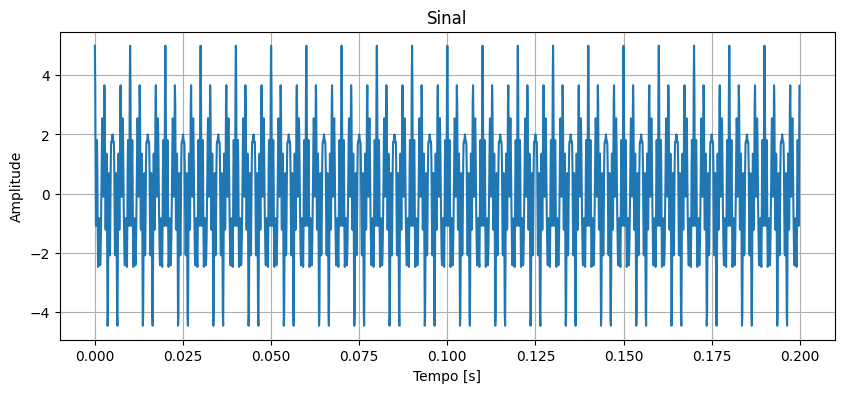

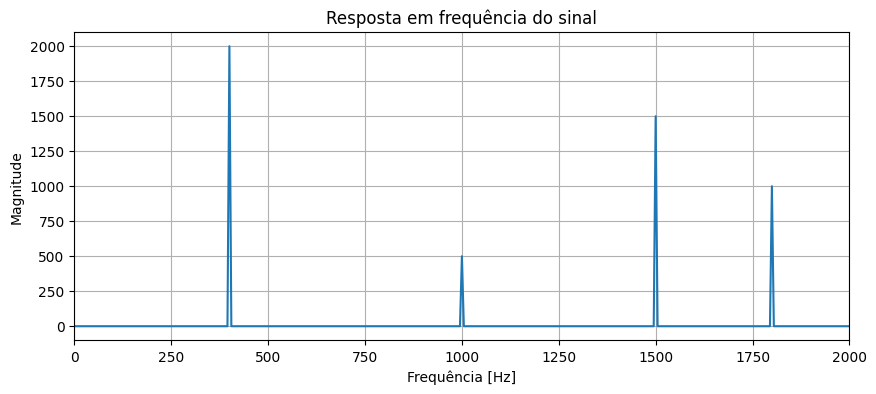

In [8]:
plot_signal(s, t, 1/Ts, limite=2000)

### 1) Utilizar as funções da biblioteca Python ScyPy.Signal para construir um filtro Windowed-sinc (sem ripple na banda de passagem) para reduzir a amplitude das componentes de 1000Hz e de 1500Hz para menos de 1% de suas amplitudes originais. É desejável que o filtro não afete a amplitude da componente que deve permanecer no sinal (tolerância de 1%). Utilizar pelo menos três tipos de funções diferentes para a geração de kernels diferentes e compare as respostas em frequência de cada um deles. Forneça:

In [9]:
def plot_kernel(kernel, name, fs):
    plt.figure(figsize=(10, 4))
    plt.title("Resposta ao impulso do filtro")
    plt.stem(np.arange(len(kernel)), kernel)
    plt.grid()
    plt.xlabel("Amostras")
    plt.ylabel("Amplitude")

    plt.figure(figsize=(10, 4))
    w, h = signal.freqz(kernel, worN=8000, fs=fs)
    plt.plot(w, 20 * np.log10(np.abs(h)), label=f"{name} Window")
    plt.title("Resposta em Frequência dos Filtros")
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Ganho (dB)")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 2000)
    plt.show()

Analisando ganhos para Hamming Window:
  Freq 400 Hz: Gain = 0.99956, Amplitude Original: 2, Amplitude Filtrada: 1.9991105347655755
  Freq 1000 Hz: Gain = 0.00173, Amplitude Original: 0.5, Amplitude Filtrada: 0.0008642967352106845
  Freq 1500 Hz: Gain = 0.00121, Amplitude Original: 1.5, Amplitude Filtrada: 0.0018083074003899797
  Freq 1800 Hz: Gain = 0.92053, Amplitude Original: 1, Amplitude Filtrada: 0.9205334265004814


Analisando ganhos para Blackman Window:
  Freq 400 Hz: Gain = 0.99996, Amplitude Original: 2, Amplitude Filtrada: 1.9999237033750403
  Freq 1000 Hz: Gain = 0.00017, Amplitude Original: 0.5, Amplitude Filtrada: 8.290772474414676e-05
  Freq 1500 Hz: Gain = 0.01073, Amplitude Original: 1.5, Amplitude Filtrada: 0.016098287809582727
  Freq 1800 Hz: Gain = 0.85827, Amplitude Original: 1, Amplitude Filtrada: 0.8582694189635804


Analisando ganhos para Kaiser Window:
  Freq 400 Hz: Gain = 1.00005, Amplitude Original: 2, Amplitude Filtrada: 2.00009981919072
  Freq 1000 Hz: Gai

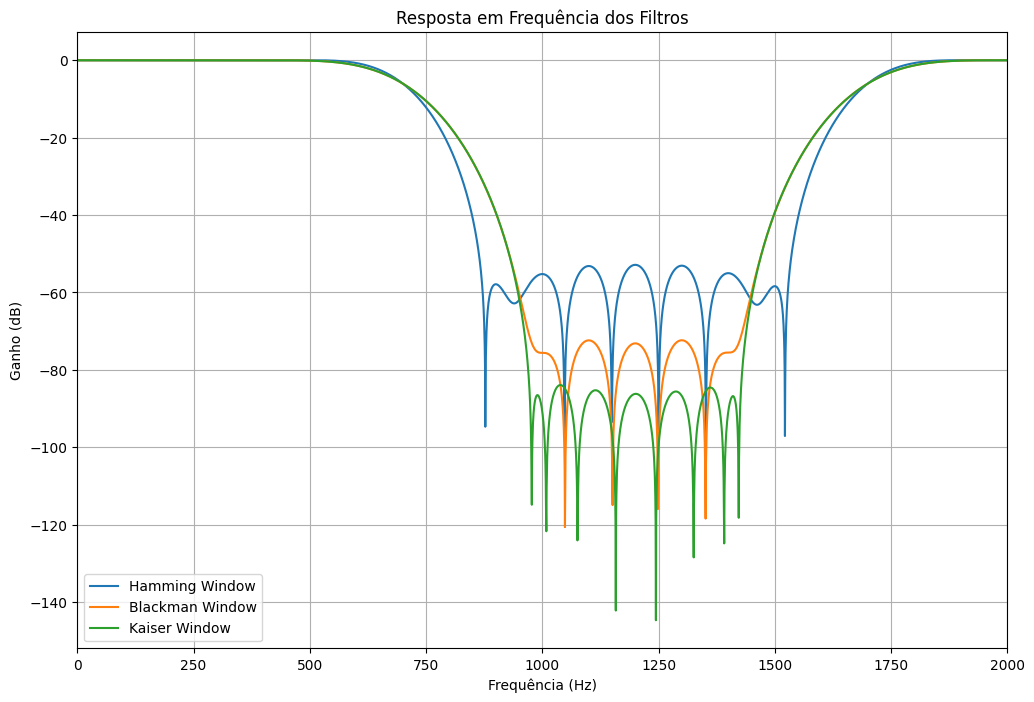

In [11]:
# Parâmetros do filtro
fs = 10000  # Frequência de amostragem
nyquist = fs / 2  # Frequência de Nyquist
frequencias = [400, 1000, 1500, 1800]  # Frequências do sinal
amplitudes_originais = [2, 0.5, 1.5, 1]  # Amplitudes originais

# Definir bandas do filtro
pass_band = [700, 1700]  # Bandas preservadas (400 Hz e 1800 Hz)
stop_band = [1000, 1500]  # Bandas rejeitadas (1000 Hz e 1500 Hz)


n_taps = 101 

def generate_kernel(pass_band, stop_band, window, fs, n_taps):
    # Combina as bandas de passagem e rejeição
    bands = [pass_band[0], pass_band[1]]
    return signal.firwin(n_taps, bands, pass_zero='bandstop', window=window, fs=fs)

# Geração de kernels com diferentes janelas
windows = {"Hamming": "hamming", "Blackman": "blackman", "Kaiser": ("kaiser", 8.6)}
kernels = {}

for window_name, window in windows.items():
    kernel = generate_kernel(pass_band, stop_band, window, fs, n_taps)
    kernels[window_name] = kernel

# Resposta em frequência e análise
plt.figure(figsize=(12, 8))
for name, kernel in kernels.items():
    w, h = signal.freqz(kernel, worN=8000, fs=fs)
    plt.plot(w, 20 * np.log10(np.abs(h)), label=f"{name} Window")
    print(f"Analisando ganhos para {name} Window:")
    for f, amp in zip(frequencias, amplitudes_originais):
        gain = np.abs(np.interp(f, w, np.abs(h)))
        print(f"  Freq {f} Hz: Gain = {gain:.5f}, Amplitude Original: {amp}, Amplitude Filtrada: {gain * amp}")
    print("\n")

plt.title("Resposta em Frequência dos Filtros")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Ganho (dB)")
plt.grid(True)
plt.legend()
plt.xlim(0, 2000)
plt.show()


### 2) Executar a filtragem do sinal. Forneça:

In [12]:
def cortar_transitorio(sinal,filtrado):
    dif = len(filtrado) - len(sinal)
    if dif % 2 == 0:
        return filtrado[int(dif/2):len(filtrado)-int(dif/2)]
    else:
        return filtrado[int(dif/2):len(filtrado)-int(dif/2)-1]

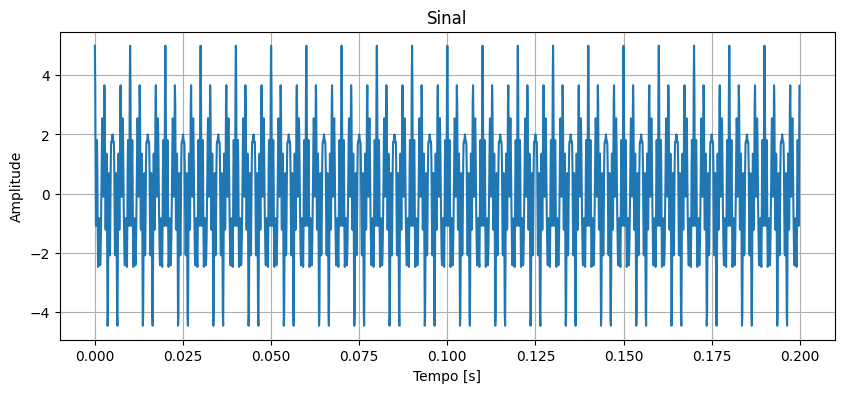

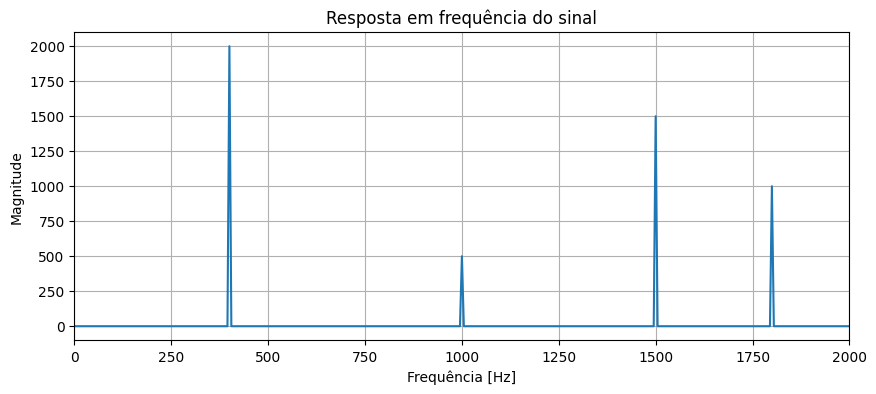

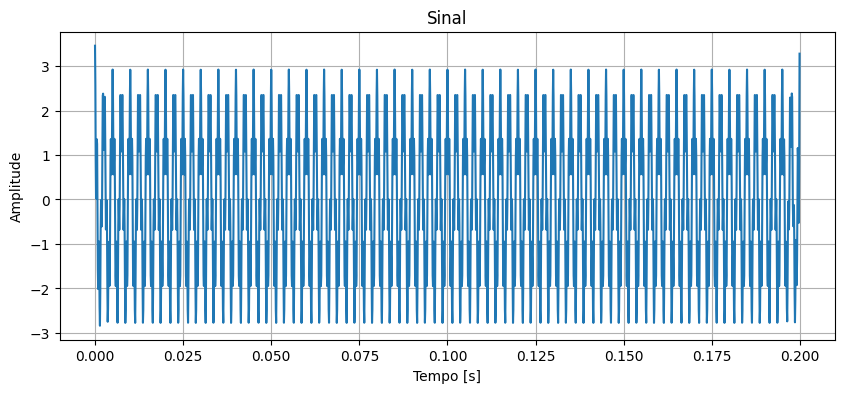

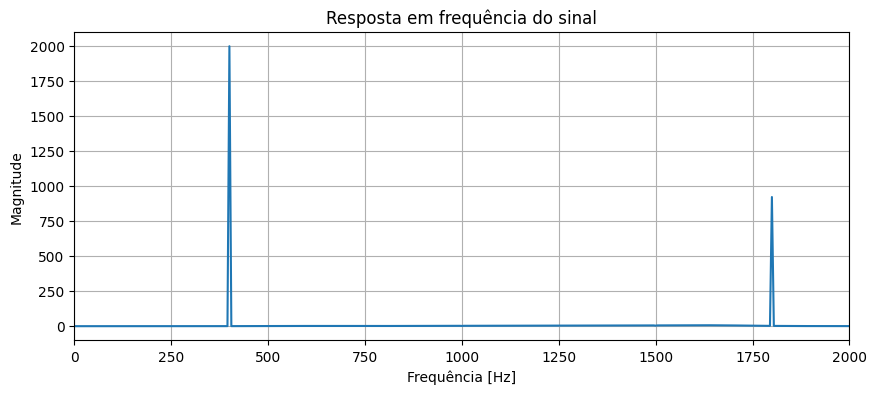

In [13]:
# Utilizando o filtro de Hamming
kernel = kernels["Hamming"]
sinal_filtrado = np.convolve(s, kernel)

sinal_filtrado_ = cortar_transitorio(s, sinal_filtrado)
plot_signal(s, t, 1/Ts, limite=2000)
plot_signal(sinal_filtrado_, t, 1/Ts, limite=2000)

### 3) Para o sinal de EEG fornecido junto a esse guia, gravado no formato EDF+. Projete um filtro para eliminar o artefato técnico de ambiente (interferência da rede elétrica). No cabeçalho de cada sinal estão presentes as informações necessárias para sua identificação como um canal correspondente do sistema internacional 10-20. Utilize o índice do canal representado pelo resto da divisão do seu número de matricula por vinte. (índice = matricula%20)


In [14]:
import os
from pathlib import Path
from pyedflib import highlevel


path = "4.edf"
signals, signal_headers, header = highlevel.read_edf(path)

In [15]:
n = len(signals)
canal = 2021007366 % 20

amostras = len (signals[canal])

print(signal_headers[canal])
fs = 200
Ts = 1/fs
t = np.arange(0,amostras*Ts,Ts)
print(signals[canal])

{'label': 'T3-REF', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 200.0, 'physical_min': -200.0, 'digital_max': 2048, 'digital_min': -2048, 'prefilter': 'LP:70Hz HP:0.1Hz N:60Hz', 'transducer': ''}
[  0.         0.         0.       ...   5.46875  -23.046875   3.125   ]


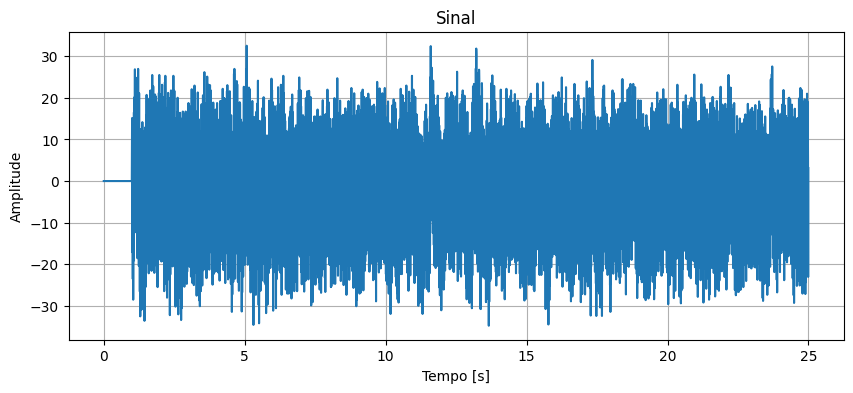

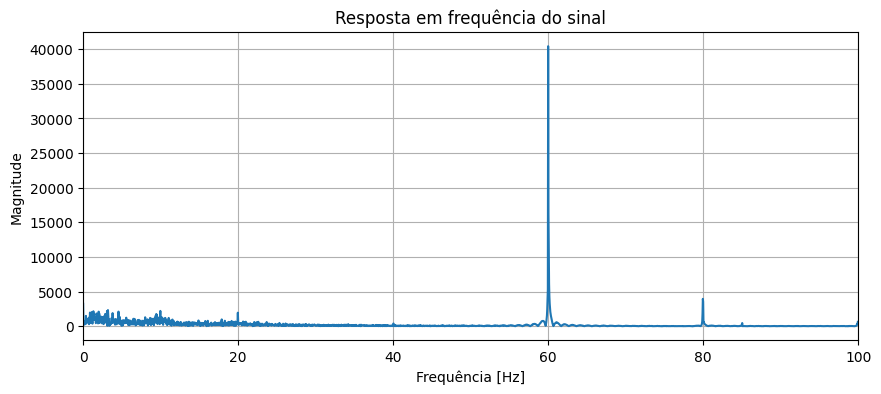

In [16]:
s = signals[canal]
plot_signal(s, t, fs, limite=100)

In [17]:
bandas_rejeitadas = [18, 22, 55, 65, 75, 85]

kernel = signal.firwin(101, bandas_rejeitadas, pass_zero='bandstop', window="hamming", fs=fs)

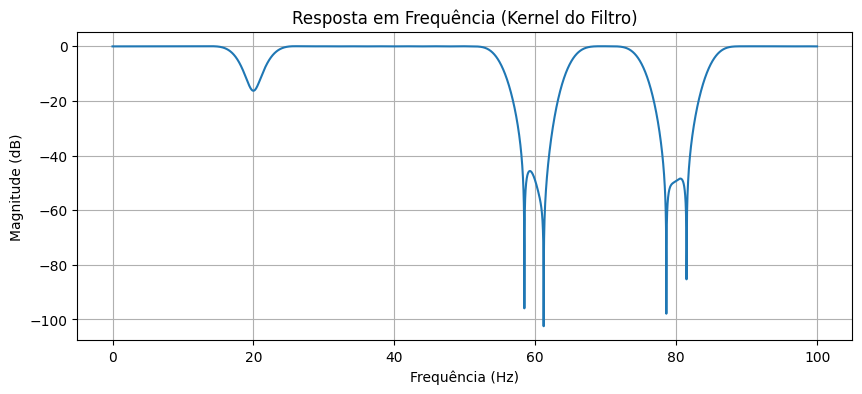

In [18]:
plt.figure(figsize=(10, 4))
w, H = signal.freqz(kernel, worN=8000, fs=fs)
plt.plot(w, 20 * np.log10(abs(H)))  # Magnitude em dB
plt.title("Resposta em Frequência (Kernel do Filtro)")
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequência (Hz)")
plt.grid()
# plt.xlim(0, 2000)

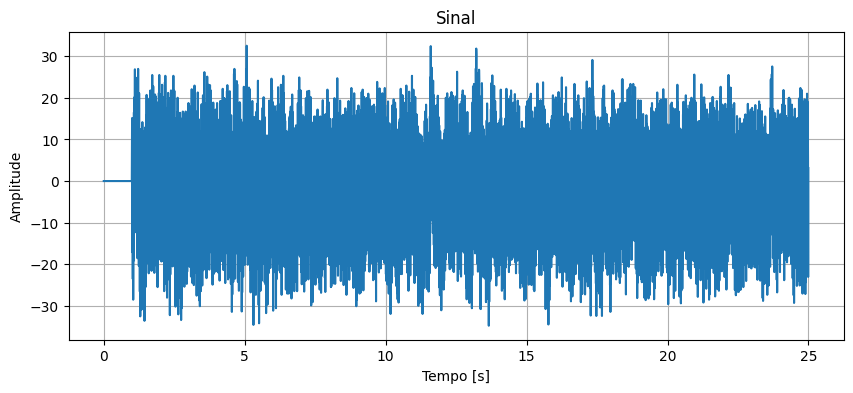

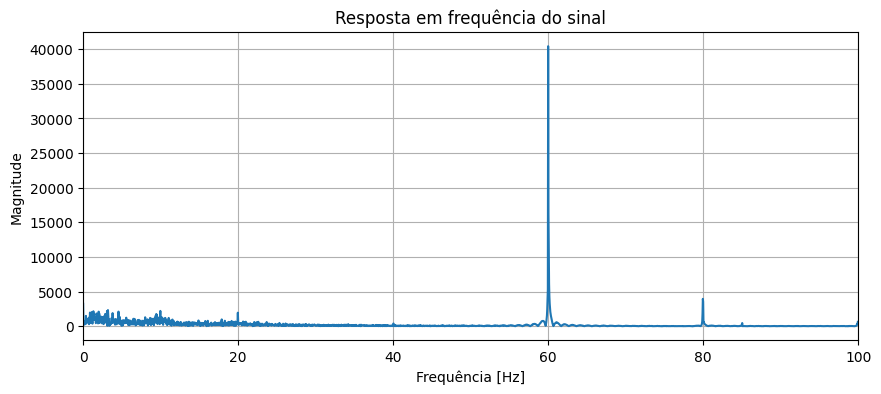

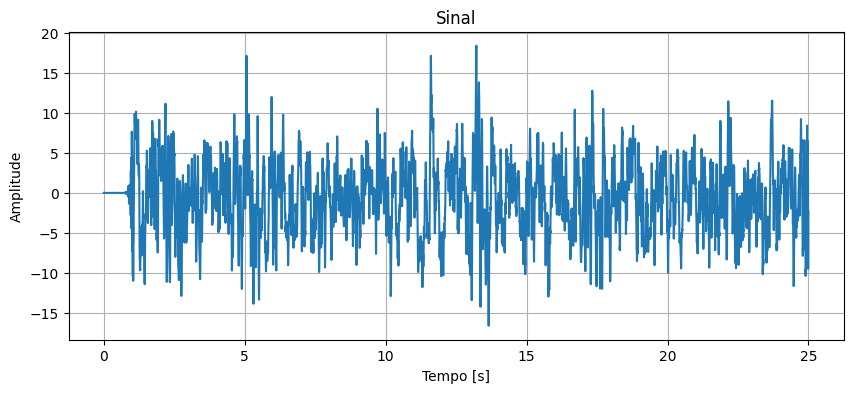

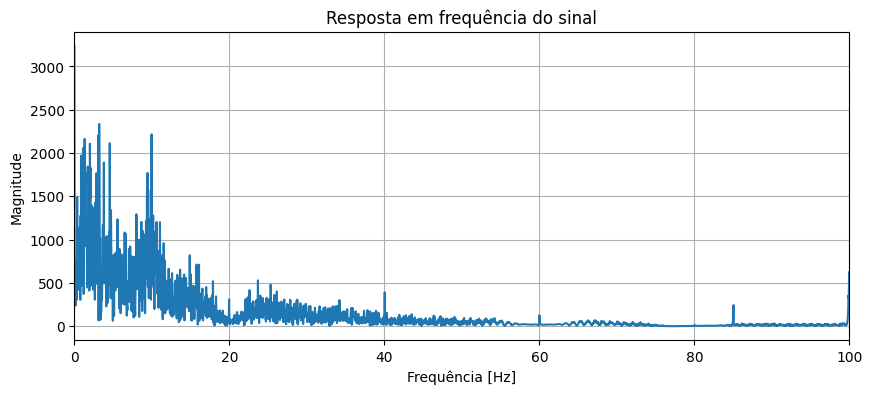

In [19]:
sinal_filtrado = np.convolve(s, kernel)

sinal_filtrado_ = cortar_transitorio(s, sinal_filtrado)
plot_signal(s, t, 1/Ts, limite=100)
plot_signal(sinal_filtrado_, t, 1/Ts, limite=100)

### 4) Projetar filtros passa banda, para separar cada uma das atividades delta, theta, alfa e beta, no sinal do exercício 3. Apresente os gráficos de resposta em frequência dos filtros, bem como o sinal correspondente a cada uma das atividades.

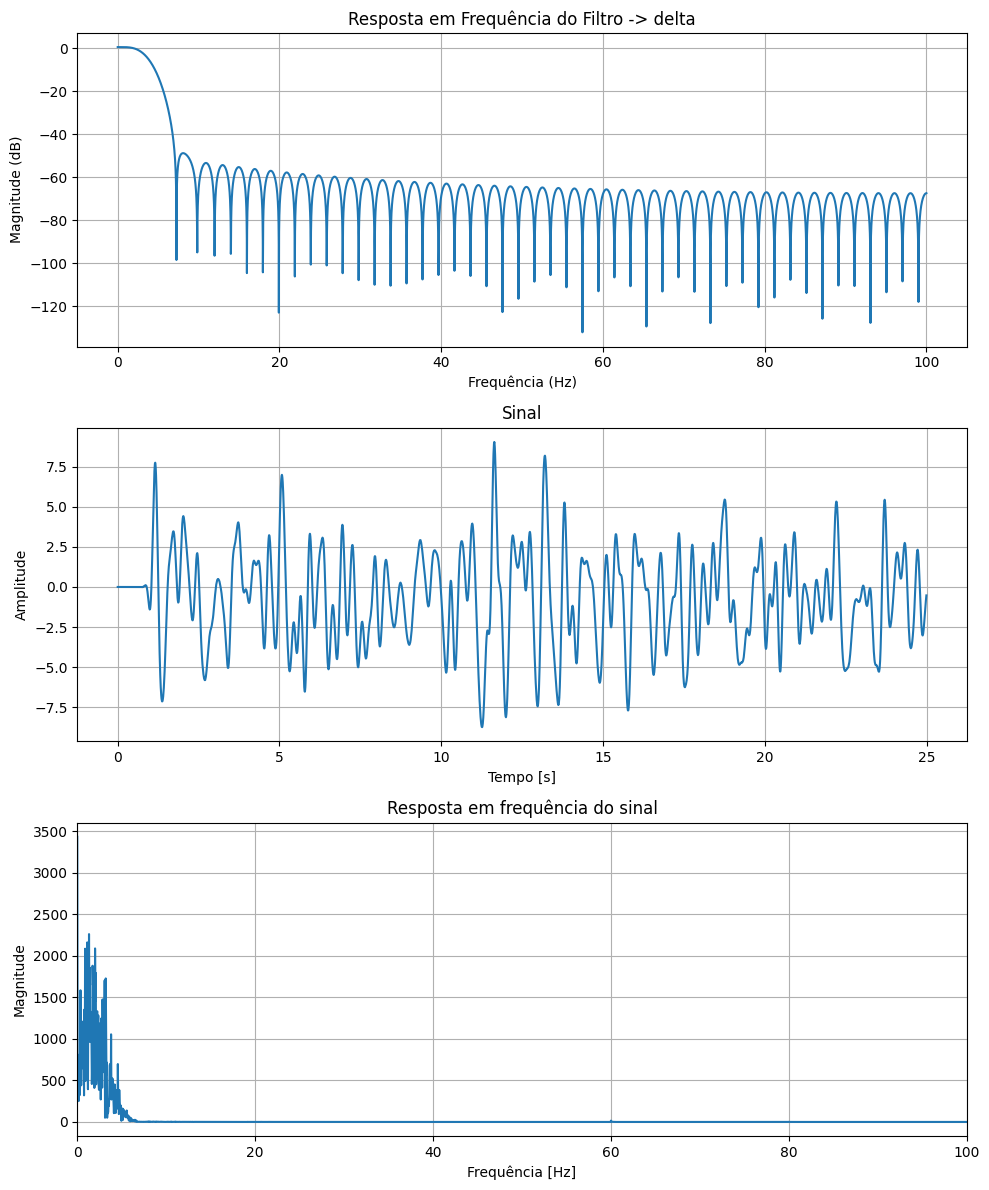

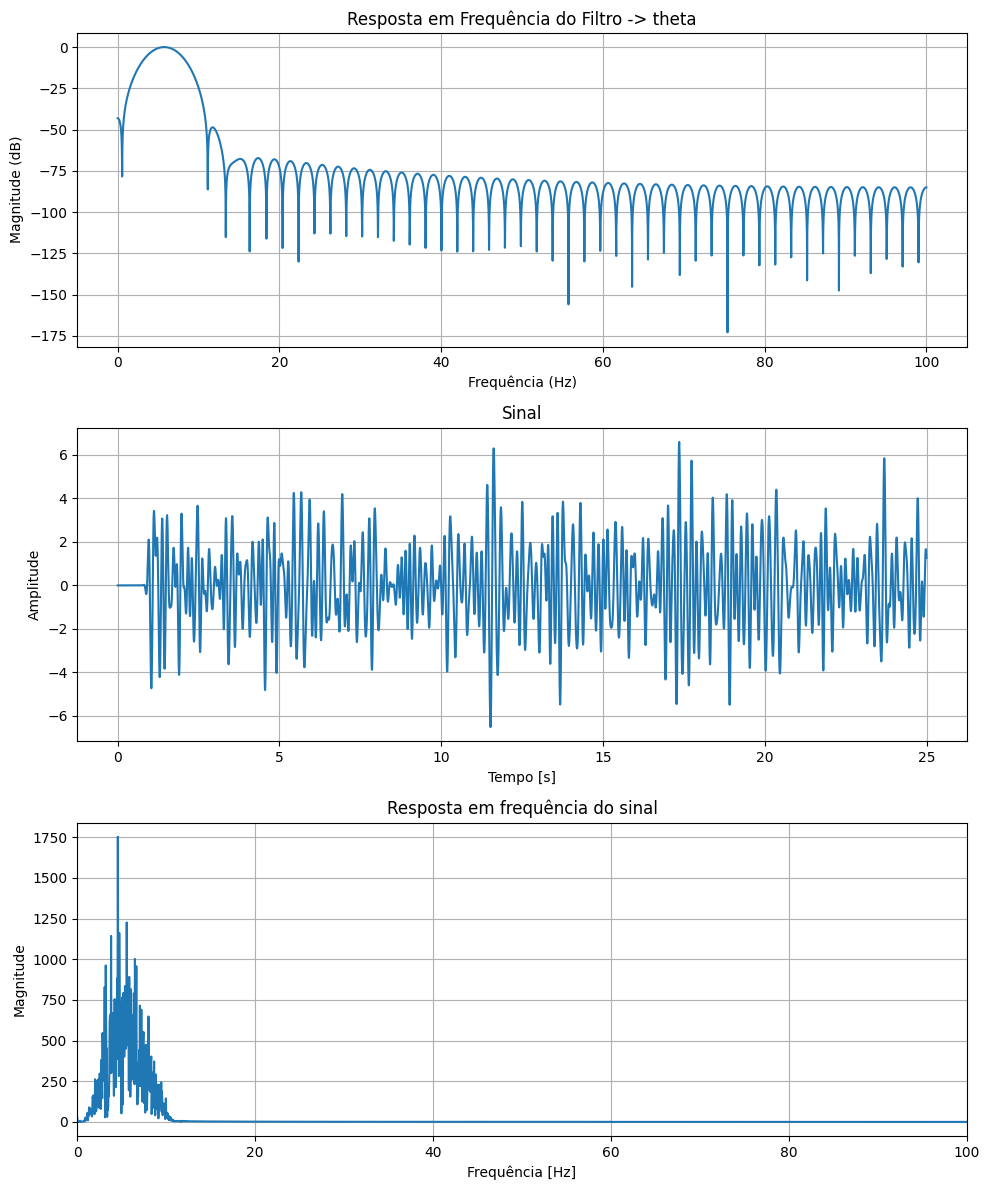

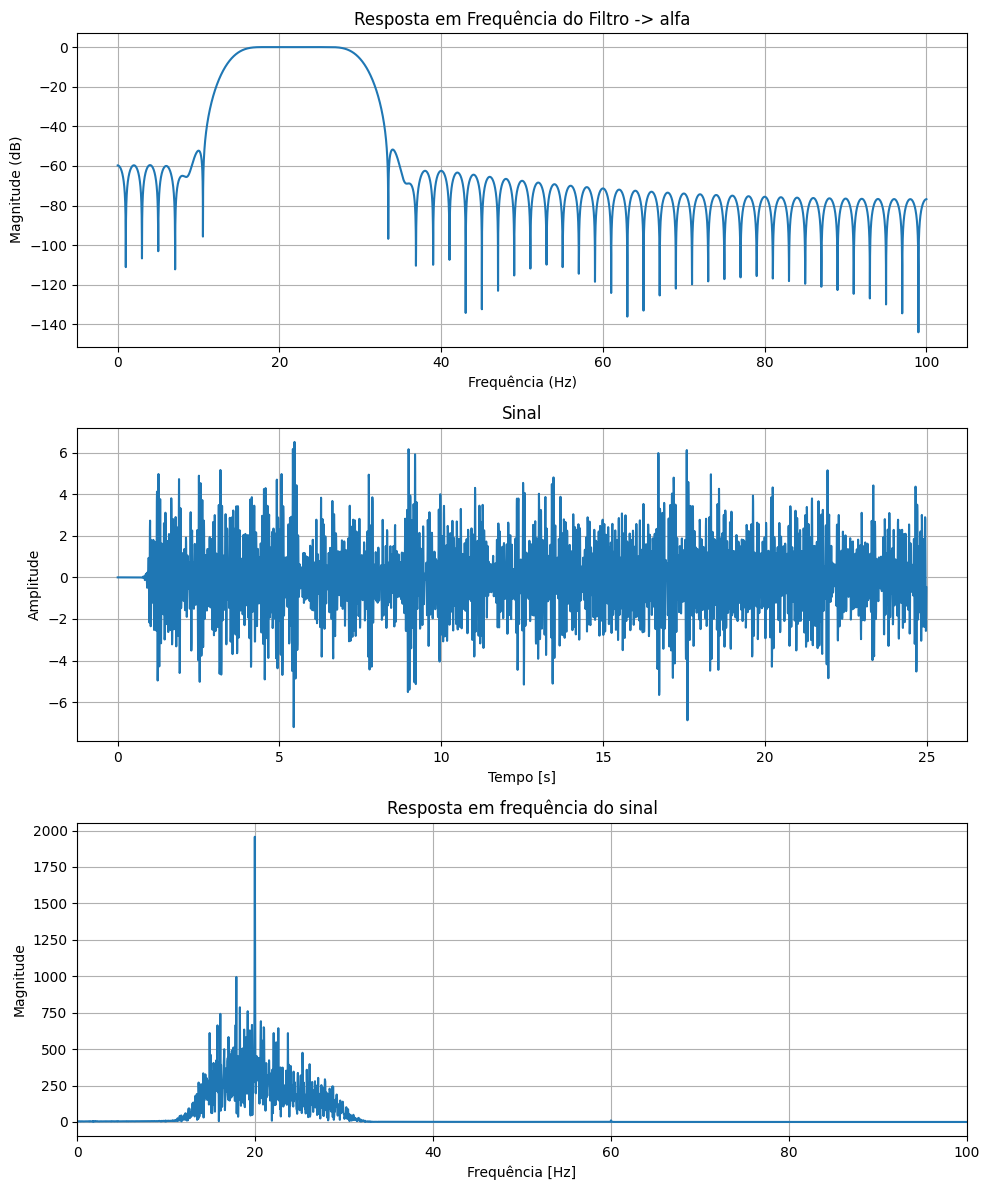

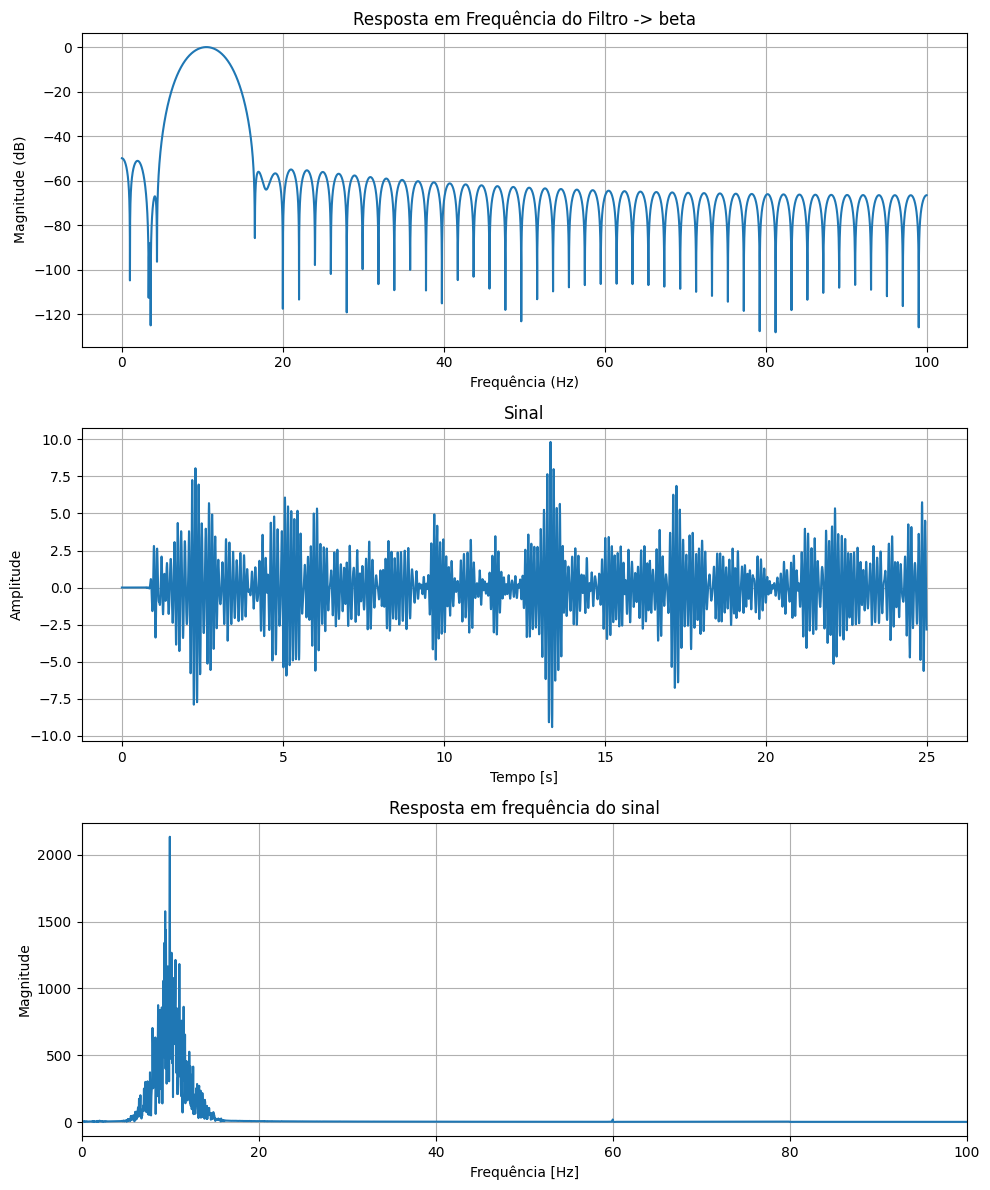

In [22]:
bandas = {
  "delta": [0.2, 3.7],
  "theta": [3.8, 7.7],
  "alfa": [14, 30],
  "beta": [8, 13]
}


for atividade, banda in bandas.items():
  kernel = signal.firwin(101, banda, pass_zero='bandpass', window="hamming", fs=fs)

  sinal_filtrado = np.convolve(s, kernel)
  sinal_filtrado_ = cortar_transitorio(s, sinal_filtrado)



  fig, axs = plt.subplots(3, 1, figsize=(10, 12))  # 3 linhas, 1 coluna
  w, h = signal.freqz(kernel, worN=8000, fs=fs)
  axs[0].plot(w, 20 * np.log10(abs(h)))  # Magnitude em dB
  axs[0].set_title(f"Resposta em Frequência do Filtro -> {atividade}")
  axs[0].set_ylabel("Magnitude (dB)")
  axs[0].set_xlabel("Frequência (Hz)")
  axs[0].grid()

  # Sinal no domínio do tempo
  axs[1].plot(t, sinal_filtrado_)
  axs[1].set_title("Sinal")
  axs[1].set_xlabel("Tempo [s]")
  axs[1].set_ylabel("Amplitude")
  axs[1].grid(True)

  # Resposta em frequência (FFT)
  frequencia_fft = np.fft.fftfreq(len(sinal_filtrado_), 1/fs)
  espectro_fft = np.fft.fft(sinal_filtrado_)
  axs[2].plot(frequencia_fft[:len(frequencia_fft)//2], np.abs(espectro_fft)[:len(espectro_fft)//2])
  axs[2].set_title("Resposta em frequência do sinal")
  axs[2].set_xlabel("Frequência [Hz]")
  axs[2].set_ylabel("Magnitude")
  axs[2].grid(True)
  axs[2].set_xlim(0, 100)

  # Ajustar espaçamento entre subplots
  plt.tight_layout()
  # Mostrar os subplots
  plt.show()




